# Multilayer Perceptrons - MLP

This notebook will explore and implement a MLP based neural network for next character pedictions based on the paper: [A Neural Probablisitc Language Model by Bengio, et al.](https://dl.acm.org/doi/pdf/10.5555/944919.944966)

In this paper the authors attempt to address the "curse of dimensionality" (a word
sequence on which the model will be tested is likely to be different from all the word sequences seen
during training)

The paper aims to mitigate this by "learning a distributed representation for words which allows each training sentence to inform the model about an exponential number of semantically neighboring sentences."

## Probability of Next Word
$$\hat{P}(w_1^T) = \prod_{t=1}^{T} \hat{P}(w_t | w_1^{t-1})$$




## MLP Diagram
![MLP Model](img/mlp_diagram.png)

In [48]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
SEED = 2697
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [49]:
# Read in all the words
words = open("../data/names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [1]:
# Build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0 # Create the special start of word/end of word token and assign it to label 0
itos = {i:s for s,i in stoi.items()}


NameError: name 'words' is not defined

In [51]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [52]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## Creating Context

If we create a dataset X which is tracking words (or characters in this case) two steps before the current word and a dataset Y which contains the following word we will be able to create a neural network that will have weights tuned to have some numerical model of these previous word relationships

This is what builds "context"!

In [53]:
# Let's build a look up table C - embedding tables
torch.manual_seed(SEED)
C = torch.randn((27,2))

C.shape, X.shape

(torch.Size([27, 2]), torch.Size([228146, 3]))

In [54]:
# Embed X in C ... This is like a forward pass?
emb = C[X] # <-- This is so cool python list comprehension. In this case we are mapping
emb.shape

torch.Size([228146, 3, 2])

In [55]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

Torch tensor magic - using the cat function we can reshape a tensor.
In this case we have out embedding matrix. This matrix is similar to a linear layer. We are mapping out index tokens for the inputs (the context list) to two randomly initialiazed look-up table. Since the embedding matrix has a size of [32,3,2] and our weights layer is [6,100] we cannot perform matrix multiplication. Here we see the function `torch.cat([list of tensors to concatenate], dimension you wish to cat along)`. 

The first example is not ideal because it is limited to a context window of 3. If we use a function called `torch.unbind(input, dim=0)` our tensor `emb` will be cated together for as many context variables there are (1 being the dimension where these variables are stored). 

In [56]:
torch.cat([emb[:,0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape, torch.cat(torch.unbind(emb, 1), 1).shape

(torch.Size([228146, 6]), torch.Size([228146, 6]))

In [57]:
# There is an even more efficient method using view
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [58]:
a.shape

torch.Size([18])

In [59]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

 the tensor object is stored strictly as a one dimensional array in memory. When we call `torch.view` we are able to choose how we are viewing the data in memory. So we can reshape any tensor array as long as the shape is made of multiples of len(tensor) and equals that length

In [60]:
#if emb.view([32,6]).shape == torch.cat(torch.unbind(emb,1),1).shape:
#    print("hooray")


In [61]:
# Now remember we have to account for possible differences in how many values ar in X. For the exmple we used 32, but the amount of input values may vary.
# Using -1 -> pytorch will infer what it should be
# Let's pass through the net!
h = emb.view(-1,6) @ W1 +b1

# Don't forget tanh activation function!
h = torch.tanh(h)
h.shape


torch.Size([228146, 100])

In [62]:
# Now the final layer!
torch.manual_seed(SEED)
W2 = torch.randn((100,27))
b2 = torch.randn(27)

## Logits
Now we pass h (hidden) to the next layer where we will get the logits of the network

What are logits - this is the raw, unnormalized( not between 0-1) output values. These are used particularly when you are applying a softmax function which will take the logits along a particular dimension and normalize them to be from values of 0-1 and sum to 1.
$$logit(p) = log(\frac{p}{1-p})$$

$$softmax(z)_i = \frac{e^{z_i}}{\Sigma_{j=1}^{K}e^{z_j}}$$

Next we have log counts. This refers to the logarithm of some count or frequency of data - this is useful when data spans over severl orders of magnitude. (text mining, bioinformatics)

Logarithmic transformation ca help in these cased by reducing the range and dampening th effect of outliers or extreme values.

It is important to not when taking the log of some count adding 1 will help account for count = 0 where log(0) is undefined.

For us we already have the log counts (logits) and in order to move back to get the counts we simply exponentiate our value to undo the logarithmic transformation.

In [63]:
# find the logits
logits = h @ W2 +b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

# Index into the rows of prob and pluck out the value of the probability assigned by to the correct character
# Take the log of these probabilities, then find the mean over the whole dataset X, times -1 
# This is how we find the negative log likelihood loss
loss = -prob[torch.arange(emb.shape[0]),Y].log().mean()
loss

tensor(18.8977)

## Way Cool Let's put it all together!

In [64]:

# Create a generator for reproducability
g = torch.Generator().manual_seed(SEED)

# Build our parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"Number of Parameters: {sum(p.nelement() for p in parameters)}")

Number of Parameters: 3481


In [65]:
# Create a Learning Rate Scheduler
lre = (torch.linspace(-3, 0, 1000))
lrs = 10**lre


In [66]:
for p in parameters:
    p.requires_grad = True

lri = []
lossi = []
epochs = 10000
for epoch in range(epochs):
# minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward Pass
    # Get the embed X into C
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (6,100)
    logits = h @ W2 + b2 # (32,27)

    # This is jst classification. F.cross_entropy(logits, Y) will perform the same operations more efficiently.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])

    # Backward Pass
    # Zero the parameter gradients
    for p in parameters:
        p.grad = None # Set optim.zero_grad()
    # Update gradients
    loss.backward()
    # Update parameters by the newly calculated gradients
    #lr = lrs[epoch]
    lr = 10**-1
    for p in parameters:
        p.data += -lr * p.grad # 0.1 is the learning rate

    # lri.append(lre[epoch])
    # lossi.append(loss.item())
    
    #print(f"Epoch: {epoch} | Loss: {loss}")


In [67]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
f"{loss=}"

'loss=tensor(2.4738, grad_fn=<NllLossBackward0>)'

In [68]:
# Looking for the best learning rate
#plt.plot(lri, lossi)

In [69]:
# training split, dev/validation split, test split
# 80|10|10
# Build the dataset

def build_dataset(words):
    block_size = 5 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [70]:
import random
random.seed(SEED)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


#### Hyperbolic Tangent function

### The Hyperbolic Tangent Function in Machine Learning

The hyperbolic tangent function, often denoted as \( \tanh(x) \), is a popular activation function used in machine learning, particularly in neural networks. The function maps any real-valued input to the range between -1 and 1, which can be useful for normalizing the output of the neurons.

#### Formula:

$$\tanh(x) = \frac{{e^x - e^{-x}}}{{e^x + e^{-x}}}$$

#### Properties:

1. **Non-linearity**: Despite being a smooth curve, it is non-linear. This means it can handle the complexities that arise during learning.
2. **Centered at Zero**: Unlike the sigmoid function, whose output is in the range \([0, 1]\), the output of the hyperbolic tangent function is in the range \([-1, 1]\). This can make learning easier, as the mean of the outputs is centered around zero.
3. **Smooth Function**: The function is differentiable, meaning we can find the derivative, which is essential for gradient-based optimization methods like gradient descent.
4. **Vanishing Gradient**: Similar to the sigmoid function, the hyperbolic tangent function also suffers from the vanishing gradient problem, albeit to a lesser extent. For very high or very low values of \( x \), the function becomes almost flat, causing gradients to vanish.

#### When to Use:

The \(\tanh\) function is commonly used in feed-forward neural networks and recurrent neural networks (RNNs), although it's less common in convolutional neural networks (CNNs) where ReLU and its variants have become more standard.

##### Advantages:

- Its output is zero-centered, making it easier for the model to learn from error.
- It's non-linear, which means it can learn from the error and make adjustments, ideal for complex problem-solving.

##### Disadvantages:

- Like the sigmoid function, it can also suffer from the vanishing gradient problem, which can slow down the learning process.

Overall, the hyperbolic tangent function is a good choice when you want your output to be bounded and zero-centered, and you're not overly concerned about the vanishing gradient problem.

In [71]:
import numpy as np
# Need to keep track of the appropriate shape of emb

# Create a generator for reproducability
g = torch.Generator().manual_seed(SEED)

# Build our parameters
C = torch.randn((27,30), generator=g)
W1 = torch.randn((150,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad_(True)

lossi = []
stepsi = []

epochs = 200000
for epoch in range(epochs):
    # minibatch construct
    # By creating this random tensor of shape (32,) we can collect randomized mini batches of the training dataset
    ix = torch.randint(0, X_train.shape[0], (32,))

    # Forward Pass
    # Get the embed X into C --> When we index X_train by the tensor ix (32,) we will generate a new list of shape (32,context_length)
    # This new tensor will thenbe mapped to the values in C
    emb = C[X_train[ix]] # 
    h = torch.tanh(emb.view(-1,W1.shape[0]) @ W1 + b1) # 
    logits = h @ W2 + b2 # 

    # This is jst classification. F.cross_entropy(logits, Y) will perform the same operations more efficiently.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix])

    # Backward Pass
    # Zero the parameter gradients
    for p in parameters:
        p.grad = None # Set optim.zero_grad()
    # Update gradients
    loss.backward()
    # Update parameters by the newly calculated gradients
    lr_min = 10**-2
    lr_max = 10**-1
    lr = lr_min + ((lr_max - lr_min)/2)*(1+np.cos((epoch/epochs)*np.pi)) 
    #lr = 10**-1 if epoch < 50000 else 10**-2
    for p in parameters:
        p.data += -lr * p.grad # 0.1 is the learning rate

    stepsi.append(epoch)
    lossi.append(loss.log10().item())



In [72]:
epochs = 200000
for epoch in range(epochs):
    # minibatch construct
    # By creating this random tensor of shape (32,) we can collect randomized mini batches of the training dataset
    ix = torch.randint(0, X_train.shape[0], (32,))

    # Forward Pass
    # Get the embed X into C --> When we index X_train by the tensor ix (32,) we will generate a new list of shape (32,context_length)
    # This new tensor will thenbe mapped to the values in C
    emb = C[X_train[ix]] # 
    h = torch.tanh(emb.view(-1,W1.shape[0]) @ W1 + b1) # 
    logits = h @ W2 + b2 # 

    # This is jst classification. F.cross_entropy(logits, Y) will perform the same operations more efficiently.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix])

    # Backward Pass
    # Zero the parameter gradients
    for p in parameters:
        p.grad = None # Set optim.zero_grad()
    # Update gradients
    loss.backward()
    # Update parameters by the newly calculated gradients
    lr = 10**-3 if epoch < 50000 else 10**-3
    for p in parameters:
        p.data += -lr * p.grad # 0.1 is the learning rate

    stepsi.append(epoch)
    lossi.append(loss.log10().item())

In [73]:
print(f"Loss: {loss.item()}")

Loss: 2.2918648719787598


In [74]:
# Evaluate
with torch.inference_mode():
    emb = C[X_val]
    h = torch.tanh(emb.view(-1,W1.shape[0]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_val)
f"{loss=}"

'loss=tensor(2.1997)'

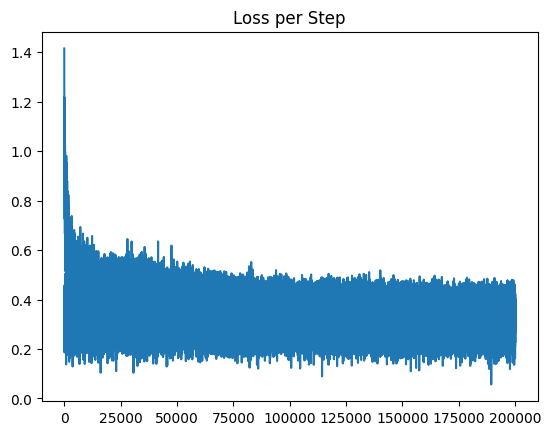

In [75]:
plt.title("Loss per Step")
plt.plot(stepsi, lossi);

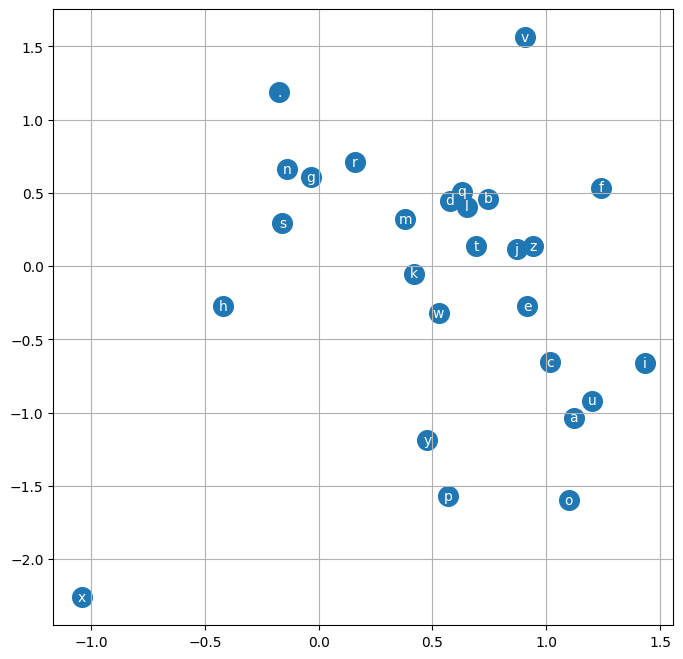

In [76]:
# View the embedding space
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

## Sampling in a Next Token Prediction Model

When working with next-token prediction models, the initial context vector plays a critical role. Typically, this context vector is initialized to a specific state, such as an array of zeros or a "start-of-sequence" token.

### The Power of Embedding

The concept of embedding transforms a discrete set of tokens into a continuous vector space. This transition from a discrete to a continuous representation is not only fascinating but also opens doors to uncover complex relationships between tokens.

#### Vocabulary Mapping

Before feeding the data into the model, we usually map the vocabulary to integers in a process known as tokenization. In this example, the character set comprises 27 discrete characters (`a-z` and `.`), each mapped to a unique integer.

#### Continuous Hyperspace

Once the tokens are in a continuous space, we gain the ability to capture nuanced relationships among them. The high-dimensional nature of this space — often referred to as "continuous hyperspace" — allows for feature mapping that can elegantly model the similarity between contexts based on their proximity in this space.

#### Why Does This Matter?

By embedding our tokens into a high-dimensional space, we gain the advantage of being able to calculate various similarity measures (e.g., cosine similarity, Euclidean distance) between contexts. These measures can provide insights into the relationships between different contexts, thereby aiding in better model predictions.

### Forward Pass

After embedding the tokens into a continuous space, the next step is to pass these embeddings through the neural network. During this forward pass, the model computes logits for each potential next token in the vocabulary.

#### Softmax Normalization

We then normalize these logits using a softmax function, which converts the logits into probabilities. The softmax function ensures that the sum of the probabilities for all possible next tokens equals 1.

#### Sampling using `torch.multinomial`

Finally, to generate the next token, we sample from this probability distribution. The `torch.multinomial` function in PyTorch is commonly used for this. It takes the softmax output and selects a token index based on the probabilities. The sampled index can then be converted back into its corresponding token using our initial vocabulary mapping.

#### Why `torch.multinomial`?

The advantage of using `torch.multinomial` over other sampling methods (like `argmax`) is that it allows the model to introduce variability in its generated sequences. Instead of always picking the most probable next token, `torch.multinomial` samples based on the given probability distribution, introducing an element of randomness that makes the model's output more dynamic and versatile. This function takes a vector in continuous space and returns an integer in discrete space.

#### How does `torch.multinomial` do this?

The output predictions acquired by the forward pass give us what is called a multinomial distribution (this is the multi catagorical probabilities of each possible token). In order to sample from this distribution we use this function which in fact utilizes a 'Cumulative Distribution Function (CDF)' of the prediction probabilities.

#### How does CDF work?

In a Cumulative Distribution Function (CDF) for a discrete random variable (like a multinomial distribution), each entry at index i of the CDF is the sum of all probabilities from index 0 to i in the original probability distribution. The last entry of the CDF will always be 1, representing the total probability.

When you sample a random number between 0 and 1, you can then use this CDF to determine which category gets selected. Categories with higher probabilities will indeed have wider "gaps" in the CDF, making it more likely that a random number will fall within that gap.

In other words, the CDF allows you to maintain the original probability distribution (ensuring that outcomes with higher probabilities are more likely to be selected) while still introducing a degree of randomness in the selection process.


In [77]:
# Sample from the model
# g = torch.Generator().manual_seed(SEED+10)
block_size = 5
for _ in range(10):
    out = []
    context = [0] * block_size # initialize word
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=None).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0 :
            break
    print(''.join(itos[i] for i in out))

tonis.
jescariel.
xamiye.
dirrech.
norei.
cimenzia.
macyn.
liral.
jir.
sekardon.
